# PROMPT:
# Zdefiniuj parametry dla uproszczonej symulacji kryptosystemu QC-MDPC.
# Użyj biblioteki numpy.
# Parametry:
# N = 997  (długość bloku cyklicznego, liczba pierwsza)
# w = 15   (waga Hamminga klucza prywatnego h0 - liczba jedynek)
# t = 15   (waga błędu, który będziemy próbować dekodować)
#
# Napisz funkcję pomocniczą `get_cyclic_distances(vector, N)`, która przyjmuje binarny wektor (numpy array)
# i zwraca listę wszystkich odległości cyklicznych między każdą parą jedynek w tym wektorze.
# Pamiętaj: odległość cykliczna między indeksami i oraz j to: min(|i-j|, N - |i-j|).
# Funkcja powinna zwracać płaską listę odległości (bez zer).

In [22]:
import numpy as np

np.random.seed(0)



# Parametry systemu QC-MDPC

N = 997  # długość bloku cyklicznego

w = 15   # waga Hamminga klucza

t = 15   # waga błędu



def get_cyclic_distances(vector: np.ndarray, N: int):

    """Zwraca listę odległości cyklicznych między jedynkami w wektorze binarnym."""

    ones = np.flatnonzero(vector)

    distances = []

    for i in range(len(ones)):

        for j in range(i + 1, len(ones)):

            diff = abs(int(ones[i]) - int(ones[j]))

            dist = min(diff, N - diff)

            if dist != 0:

                distances.append(dist)

    return distances


# PROMPT:
# Zaimplementuj klasę lub funkcje symulujące "Ofiarę" (System QC-MDPC).
# 1. Funkcja `generate_key(N, w)`: zwraca losowy wektor binarny (h0) o długości N i wadze w.
# 2. Funkcja `syndrome_decoding(h0, error_vector, N, max_iter=20)`:
#    - Symuluje prosty algorytm Bit-Flipping.
#    - Oblicza syndrom s = h0 * error_vector (splot cykliczny).
#    - W pętli: oblicza liczbę niezadowolonych równań parzystości dla każdego bitu.
#    - Jeśli liczba niezadowolonych równań > threshold (np. max_unsat - delta), odwraca bit.
#    - Jeśli syndrom jest zerowy -> sukces (zwraca True).
#    - Jeśli po max_iter syndrom nadal nie jest zerowy -> porażka (zwraca False).
#
# Ważne: Zaimplementuj operacje na wektorach rzadkich lub użyj numpy roll/fft dla wydajności splotu,
# ale dla N=997 prosta implementacja na tablicach numpy wystarczy.
# Stwórz instancję klucza prywatnego `secret_key` używając tych funkcji.

In [23]:
def generate_key(N: int, w: int) -> np.ndarray:

    """Generuje losowy wektor binarny o zadanej wadze."""

    key = np.zeros(N, dtype=int)

    positions = np.random.choice(N, size=w, replace=False)

    key[positions] = 1

    return key





def syndrome_decoding(h0: np.ndarray, error_vector: np.ndarray, N: int, max_iter: int = 10):

    """Prosty algorytm Bit-Flipping; zwraca True jeśli dekodowanie się powiodło."""



    def compute_syndrome(h: np.ndarray, e: np.ndarray) -> np.ndarray:

        syndrome = np.zeros(N, dtype=int)

        for idx in np.flatnonzero(e):

            syndrome ^= np.roll(h, idx)

        return syndrome % 2



    error = error_vector.copy()

    syndrome = compute_syndrome(h0, error)

    if not syndrome.any():

        return True



    for _ in range(max_iter):

        unsat = np.zeros(N, dtype=int)

        for shift, val in enumerate(h0):

            if val:

                unsat += np.roll(syndrome, -shift)

        max_unsat = int(unsat.max())

        threshold = max_unsat - 1

        flips = unsat > threshold

        if flips.any():

            error[flips] ^= 1

            syndrome = compute_syndrome(h0, error)

            if not syndrome.any():

                return True

        else:

            break



    return not syndrome.any()





secret_key = generate_key(N, w)


# PROMPT:
# Zaimplementuj atak GJS (Guo-Johansson-Stankovski) - Reaction Attack.
# Cel: Znaleźć widmo odległości (distance spectrum) klucza prywatnego.
#
# Algorytm:
# 1. Ustaw licznik prób `num_trials = 10000` (lub mniej dla testu).
# 2. Stwórz pustą tablicę/słownik do zliczania wystąpień odległości w błędnych wektorach (`spectrum_candidates`).
# 3. W pętli `num_trials`:
#    - Wygeneruj losowy wektor błędu `e` o wadze `t`.
#    - Uruchom `syndrome_decoding(secret_key, e, N)`.
#    - Jeśli dekodowanie ZWRÓCIŁO FAŁSZ (Decoding Failure):
#        - Oblicz odległości cykliczne w wektorze `e` (użyj funkcji z kroku 1).
#        - Zaktualizuj licznik `spectrum_candidates` tymi odległościami.
#
# Wyświetl ile błędów dekodowania udało się złapać (Decoding Failure Rate).

In [ ]:
num_trials = 20000

spectrum_candidates = {}

failures = 0



for _ in range(num_trials):

    print(f"Trial {_ + 1}/{num_trials}", end='\r')

    error_vector = np.zeros(N, dtype=int)

    error_positions = np.random.choice(N, size=t, replace=False)

    error_vector[error_positions] = 1

    success = syndrome_decoding(secret_key, error_vector, N)

    if not success:
        print(f"Decoding failed on trial {_ + 1}")

        failures += 1

        dists = get_cyclic_distances(error_vector, N)

        for d in dists:

            spectrum_candidates[d] = spectrum_candidates.get(d, 0) + 1



failure_rate = failures / num_trials

print(f"Decoding failures: {failures}/{num_trials} ({failure_rate:.4f})")


Decoding failed on trial 24
Decoding failed on trial 51
Decoding failed on trial 53
Decoding failed on trial 53
Decoding failed on trial 216
Decoding failed on trial 216
Decoding failed on trial 424
Decoding failed on trial 424
Decoding failed on trial 555
Decoding failed on trial 555
Decoding failed on trial 632
Decoding failed on trial 673
Decoding failed on trial 632
Decoding failed on trial 673
Decoding failed on trial 696
Decoding failed on trial 716
Decoding failed on trial 696
Decoding failed on trial 716
Decoding failed on trial 857
Decoding failed on trial 857
Decoding failures: 11/1000 (0.0110)
Decoding failures: 11/1000 (0.0110)


# PROMPT:
# Wizualizacja wyników ataku. Użyj matplotlib.
# 1. Oblicz PRAWDZIWE widmo odległości dla `secret_key` (to jest nasz Ground Truth).
# 2. Przygotuj wykres słupkowy (bar chart):
#    - Oś X: Odległości (od 1 do N//2).
#    - Oś Y: Liczba wystąpień danej odległości w wektorach, które spowodowały błąd dekodowania.
# 3. Na tym samym wykresie wyróżnij (np. innym kolorem, np. czerwonym) te słupki,
#    które odpowiadają PRAWDZIWYM odległościom w kluczu prywatnym.
#    Pozostałe słupki (szum) niech będą np. szare lub niebieskie.
#
# Cel: Chcemy zobaczyć, czy słupki "czerwone" (z klucza) są statystycznie wyższe niż "niebieskie" (losowe).
# Dodaj tytuł "Atak GJS: Analiza Widma Odległości (Decoding Failures)".

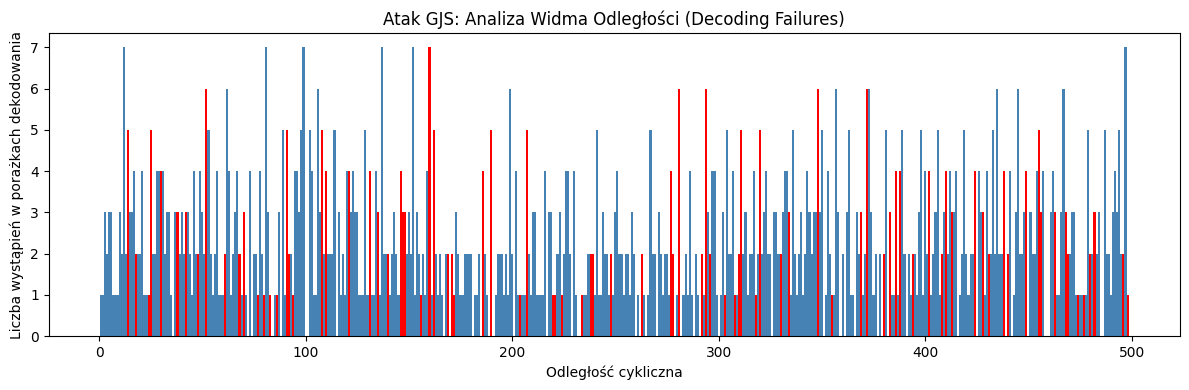

In [25]:
import matplotlib.pyplot as plt



true_distances = get_cyclic_distances(secret_key, N)

true_distance_set = set(true_distances)



max_dist = N // 2

x_vals = np.arange(1, max_dist + 1)

y_vals = np.array([spectrum_candidates.get(int(d), 0) for d in x_vals], dtype=int)

colors = ["red" if dist in true_distance_set else "steelblue" for dist in x_vals]



plt.figure(figsize=(12, 4))

plt.bar(x_vals, y_vals, color=colors, width=1.0)

plt.title("Atak GJS: Analiza Widma Odległości (Decoding Failures)")

plt.xlabel("Odległość cykliczna")

plt.ylabel("Liczba wystąpień w porażkach dekodowania")

plt.tight_layout()

plt.show()
